In [35]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import little_things_functions as ltf

# R_D with ellipse center

In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import LogStretch, ImageNormalize
from scipy.optimize import curve_fit

norm = ImageNormalize(vmin=0., stretch=LogStretch())
galaxy_name = "DDO 168"
image_168 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\d168\starless_backgroundless_d168v_aligned.fits.fit"))

def degrees_to_radians(degrees):
    return degrees * (math.pi / 180)

theta_deg = -30.167
theta = degrees_to_radians(theta_deg)

list_of_ellipse_data = [theta, 59.01, 21.11]
m = np.tan(list_of_ellipse_data[0])

def get_line_values(image, x_ax, center_of_galaxy_y, center_of_galaxy_x):
    values = []
    y_list = []
    for x in x_ax:
        y = int(-1/m * x + center_of_galaxy_y - (-1/m)*(275.67 + 175))
        if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]:
            values.append(image[y, x])
            y_list.append(y)
            
    return values, y_list

def R_D(image, distance, pixel_scale ,list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, start_of_galaxy_x, show_line_plot=True, initial_guesses=[1, 0.06, 25, 0]):
    theta, a, b = list_of_ellipse_data
    m = np.tan(theta)
    x_ax_left = np.arange(start_of_galaxy_x, center_of_galaxy_x)
    x_ax_right = np.arange(center_of_galaxy_x, center_of_galaxy_x + (center_of_galaxy_x - start_of_galaxy_x))
    values_along_line_left, y_list_left = get_line_values(image, x_ax_left, center_of_galaxy_y, center_of_galaxy_x)
  
    values_along_line_right, y_list_right = get_line_values(image, x_ax_right, center_of_galaxy_y, center_of_galaxy_x)
    y_list = np.concatenate((y_list_left, y_list_right))
    if show_line_plot:
        ax = plt.gca()
        im = ax.imshow(image, cmap='gray', origin="lower", norm=norm)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("log scale")
        angle_in_degrees = np.degrees(list_of_ellipse_data[0])
        # Create the ellipse
        #ellipse = Ellipse(xy=(center_of_galaxy_x, center_of_galaxy_y), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)
        # Add the ellipse to the axis
        #ax.add_patch(ellipse)
        plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
        plt.show()

    values_along_line = np.concatenate((values_along_line_left ,values_along_line_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
    plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
    plt.title(f"Light profile for {galaxy_name} along the major axis.")
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the galaxy')
    plt.legend()
    plt.show()

    L = len(x_ax_left)
    new_x_ax_right = []
    for i in range(0, len(x_ax_right)):
        x = (2*L - x_ax_right[i] + start_of_galaxy_x*2)
        new_x_ax_right.append(x)

    plt.scatter(x_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(new_x_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center')
    plt.legend()
    plt.show()

    def exponential_func(x, a, b, c, x0):
        return a * np.exp(b * (x - x0)) + c

    x1 = x_ax_left  # Your x values
    x2 = new_x_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right
    # Combine y-values
    y_combined = np.concatenate((y1, y2))
    x_combined = np.concatenate((x1, x2))
    # Provide initial guesses for the parameters
    popt, pcov = curve_fit(exponential_func, x_combined, y_combined, p0=initial_guesses)

    # Plot the original data and the fitted function
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.scatter(x_combined, y_combined, s=3, label='Data')
    plt.plot(x_combined, exponential_func(x_combined, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='Center of the fitted ellipse')
    plt.legend()
    plt.title(f'{galaxy_name} light profile and fitted function')
    plt.show()

    # Calculate residuals
    residuals = y_combined - exponential_func(x_combined, *popt)

    # Plot the residuals
    plt.subplot(2, 1, 2)
    plt.scatter(x_combined, residuals, s=3, label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.legend()
    plt.title('Residuals')
    plt.xlabel('x')
    plt.ylabel('Residuals')
    plt.tight_layout()
    plt.show()

    # Calculate the standard deviation errors on the parameters
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is a * exp(b * (x - x0)) + c")
    print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
    print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")
    print(f"RD is {1/popt[1]:.4f} pixels")
    R_D_pixels = 1/popt[1]
    R_D_arcsec = R_D_pixels * pixel_scale
    RD = ((distance * R_D_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD} kpc")
    #y_fitted = exponential_func(x_combined, *popt)
    #chi_squared = np.sum(((y_combined - y_fitted) ** 2) / y_fitted) 
    #print(f"Chi-squared value: {chi_squared}")
    return x_ax , values_along_line, y_list


# 2 versions of a function that finds the center of the galaxy

In [37]:
def get_line_profile_and_center_COM(image, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, start_of_galaxy_x, show_line_plot=True, ratio=0.68):
    theta, a, b = list_of_ellipse_data
    x_ax_left = np.arange(start_of_galaxy_x, center_of_galaxy_x)
    x_ax_right = np.arange(center_of_galaxy_x, center_of_galaxy_x + (center_of_galaxy_x - start_of_galaxy_x))
    values_along_line_left, y_list_left = get_line_values(image, x_ax_left, center_of_galaxy_y, center_of_galaxy_x)
    values_along_line_right, y_list_right = get_line_values(image, x_ax_right, center_of_galaxy_y, center_of_galaxy_x)
    
    y_list = np.concatenate((y_list_left, y_list_right))
    
    if show_line_plot:
        ax = plt.gca()
        im = ax.imshow(image, cmap='gray', origin="lower")
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("log scale")
        angle_in_degrees = np.degrees(theta)
        plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
        plt.show()
    
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    
    plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
    plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
    plt.title(f"Light profile for {galaxy_name} along the major axis.")
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
    plt.legend()
    plt.show()
    
    values_along_line = np.array(values_along_line)
    x_ax = np.array(x_ax)
    
    total_area = np.trapz(values_along_line, x=x_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (x_ax[1] - x_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_x_ax = x_ax[values_along_line > threshold_value]
    
    center_of_mass = np.sum(filtered_x_ax * filtered_values) / np.sum(filtered_values)
    
    print(f"Threshold value: {threshold_value}")
    print(f"Center of mass: {center_of_mass}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(x_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass, color='blue', linestyle='--', label=f'Center of Mass = {center_of_mass:.2f}')
    plt.legend()
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()
    
    return x_ax, values_along_line, y_list


In [38]:
def get_line_profile_and_center(image, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, start_of_galaxy_x, show_line_plot=True, ratio=0.68):
    theta, a, b = list_of_ellipse_data
    x_ax_left = np.arange(start_of_galaxy_x, center_of_galaxy_x)
    x_ax_right = np.arange(center_of_galaxy_x, center_of_galaxy_x + (center_of_galaxy_x - start_of_galaxy_x))
    values_along_line_left, y_list_left = get_line_values(image, x_ax_left, center_of_galaxy_y, center_of_galaxy_x)
    values_along_line_right, y_list_right = get_line_values(image, x_ax_right, center_of_galaxy_y, center_of_galaxy_x)
    
    y_ax = np.concatenate((y_list_left, y_list_right))
    
    if show_line_plot:
        ax = plt.gca()
        im = ax.imshow(image, cmap='gray', origin="lower")
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("log scale")
        plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
        plt.show()
    
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    
    plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
    plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
    plt.title(f"Light profile for {galaxy_name} along the major axis.")
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
    plt.legend()
    plt.show()
    
    values_along_line = np.array(values_along_line)
    x_ax = np.array(x_ax)
    
    total_area = np.trapz(values_along_line, x=x_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (x_ax[1] - x_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_x_ax = x_ax[values_along_line > threshold_value]
    
    # Calculate the center of mass along the X-axis using equal area concept
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    # Find the x coordinate where the cumulative intensity is half the total intensity
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_x = x_ax[com_index]
    center_of_mass_y = y_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy  (Equal Area on both sides of the center line): {center_of_mass_x}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(x_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_x, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_x:.2f}')
    plt.legend()
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()
    
    
    return x_ax, y_ax, values_along_line, center_of_mass_x, center_of_mass_y

def RD(image, distance, pixel_scale, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, start_of_galaxy_x, show_line_plot=True, ratio=0.68, initial_guesses=[1, 0.06, 25, 0]):
    theta, a, b = list_of_ellipse_data
    m = np.tan(list_of_ellipse_data[0])
    center_of_galaxy_x = int(center_of_galaxy_x)
    start_of_galaxy_x = int(start_of_galaxy_x)
    x_ax_left = np.arange(start_of_galaxy_x, center_of_galaxy_x, 1, dtype=int)
    x_ax_right = np.arange(center_of_galaxy_x, center_of_galaxy_x + (center_of_galaxy_x - start_of_galaxy_x), 1, dtype=int)
    values_along_line_left, y_list_left = get_line_values(image, x_ax_left, center_of_galaxy_y, center_of_galaxy_x, list_of_ellipse_data)
    values_along_line_right, y_list_right = get_line_values(image, x_ax_right, center_of_galaxy_y, center_of_galaxy_x, list_of_ellipse_data)
    
    y_ax = np.concatenate((y_list_left, y_list_right))
    
    if show_line_plot:
        ax = plt.gca()
        im = ax.imshow(image, cmap='gray', origin='lower')
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("log scale")
        plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
        plt.show()
    
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    
    plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
    plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
    plt.title(f"Light profile for {galaxy_name} along the major axis.")
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
    plt.legend()
    plt.show()
    
    values_along_line = np.array(values_along_line)
    x_ax = np.array(x_ax)
    
    total_area = np.trapz(values_along_line, x=x_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (x_ax[1] - x_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_x_ax = x_ax[values_along_line > threshold_value]
    
    # Calculate the center of mass along the X-axis using equal area concept
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    # Find the x coordinate where the cumulative intensity is half the total intensity
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_x = x_ax[com_index]
    center_of_mass_y = y_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy  (Equal Area on both sides of the center line): {center_of_mass_x}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(x_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_x, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_x:.2f}')
    plt.legend()
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()
    
    new_x_ax_left = x_ax[:com_index]
    new_x_ax_right = x_ax[com_index:]
    new_y_ax_left = y_ax[:com_index]
    new_y_ax_right = y_ax[com_index:]

    if len(new_x_ax_left) > len(new_x_ax_right):
        delete = len(new_x_ax_left) - len(new_x_ax_right)
        new_x_ax_left = new_x_ax_left[delete:]
        new_y_ax_left = new_y_ax_left[delete:]
    elif len(new_x_ax_left) < len(new_x_ax_right):
        delete = len(new_x_ax_right) - len(new_x_ax_left)
        new_x_ax_right = new_x_ax_right[:-delete]
        new_y_ax_right = new_y_ax_right[:-delete]
    L = len(x_ax_left)
    new_x_ax_right = []
    for i in range(0, len(x_ax_right)):
        x = (2*L - x_ax_right[i] + start_of_galaxy_x*2)
        new_x_ax_right.append(int(x))  # Ensure new_x_ax_right values are integers

    plt.scatter(x_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(new_x_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center')
    plt.legend()
    plt.show()

    def exponential_func(x, a, b, c, x0):
        return a * np.exp(b * (x - x0)) + c

    x1 = x_ax_left  # Your x values
    x2 = new_x_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right
    y_combined = np.concatenate((y2, y1))
    y_combined = y_combined[:]
    x_combined = np.concatenate((x1, x2))
    x_combined = x_combined[:]
    popt, pcov = curve_fit(exponential_func, x_combined, y_combined, p0= [1, 0.1, np.mean(x_combined), np.min(y_combined)], maxfev=10000)

    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.scatter(x_combined, y_combined, s=3, label='Data')
    plt.plot(x_combined, exponential_func(x_combined, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='Center of the fitted ellipse')
    plt.legend()
    plt.title(f'{galaxy_name} light profile and fitted function')
    plt.show()

    residuals = y_combined - exponential_func(x_combined, *popt)

    plt.subplot(2, 1, 2)
    plt.scatter(x_combined, residuals, s=3, label='Residuals')
    plt.axhline(0, color='red', linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is a * exp(b * (x - x0)) + c")
    print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
    print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")
    print(f"RD is {1/popt[1]:.4f} pixels")
    R_D_pixels = 1/popt[1]
    R_D_arcsec = R_D_pixels * pixel_scale
    RD = ((distance * R_D_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD} kpc")
   
    return x_ax, y_ax, values_along_line



In [ ]:
def RD_1(image, distance, pixel_scale, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, start_of_galaxy_x, show_line_plot=True, ratio=0.68, initial_guesses = [45, 0.1, 25, 0]):
    theta, a, b = list_of_ellipse_data
    
    def get_line_values(image, x_ax, center_of_galaxy_y, list_of_ellipse_data):
        m = np.tan(theta)
        values = []
        y_list = []
        for x in x_ax:
            y = int(m * x + center_of_galaxy_y - (m)*(y_center + y_start))
            y = int(y)  # Ensure y is an integer
            if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]:
                values.append(image[y, x])
                image[x,y] = 1000
                y_list.append(y)
        return values, y_list
    
    center_of_galaxy_x = int(center_of_galaxy_x)
    start_of_galaxy_x = int(start_of_galaxy_x)
    x_ax_left = np.arange(start_of_galaxy_x, center_of_galaxy_x, 1, dtype=int)
    x_ax_right = np.arange(center_of_galaxy_x, center_of_galaxy_x + (center_of_galaxy_x - start_of_galaxy_x), 1, dtype=int)
    values_along_line_left, y_list_left = get_line_values(image, x_ax_left, center_of_galaxy_y, list_of_ellipse_data)
    values_along_line_right, y_list_right = get_line_values(image, x_ax_right, center_of_galaxy_y, list_of_ellipse_data)
    
    y_ax = np.concatenate((y_list_left, y_list_right))
    
    if show_line_plot == True:
        ax = plt.gca()
        im = ax.imshow(image, cmap='gray', origin='lower')
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("log scale")
        plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
        plt.show()
    
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    
    plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
    plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
    plt.title(f"Light profile for {galaxy_name} along the major axis.")
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
    plt.legend()
    plt.show()
    
    values_along_line = np.array(values_along_line)
    x_ax = np.array(x_ax)
    
    total_area = np.trapz(values_along_line, x=x_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (x_ax[1] - x_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_x_ax = x_ax[values_along_line > threshold_value]
    
    # Calculate the center of mass along the X-axis using equal area concept
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    # Find the x coordinate where the cumulative intensity is half the total intensity
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_x = x_ax[com_index]
    center_of_mass_y = y_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy  (Equal Area on both sides of the center line): {center_of_mass_x}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(x_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_x, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_x:.2f}')
    plt.legend()
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()

    # Ensure values_along_line_left and values_along_line_right match x_ax slicing
    values_along_line_left = values_along_line[:com_index]
    values_along_line_right = values_along_line[com_index:]

    x_ax_left = x_ax[:com_index]
    x_ax_right = x_ax[com_index:]

    # Balance lengths
    if len(x_ax_left) > len(x_ax_right):
        delete = len(x_ax_left) - len(x_ax_right)
        x_ax_left = x_ax_left[delete:]
        values_along_line_left = values_along_line_left[delete:]
    elif len(x_ax_left) < len(x_ax_right):
        delete = len(x_ax_right) - len(x_ax_left)
        x_ax_right = x_ax_right[:-delete]
        values_along_line_right = values_along_line_right[:-delete]

    L = len(x_ax_left)
    flipped_x_ax_right = []
    for i in range(len(x_ax_right)):
        x = (2 * center_of_mass_x - x_ax_right[i])  # Flipping around the center of mass
        flipped_x_ax_right.append(int(x))  # Ensure flipped_x_ax_right values are integers

    flipped_x_ax_right = np.array(flipped_x_ax_right)  # Convert list to numpy array

    plt.scatter(x_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(flipped_x_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='center')
    plt.legend()
    plt.show()
    
    x1 = x_ax_left  
    x2 = flipped_x_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right[::-1]
    mean_y = (y1 + y2)/2
    
    def exponential_func(x, a, b, c, x0):
        return a * np.exp(b * (x - x0)) + c

    # Provide initial guesses for the parameters
    popt, pcov = curve_fit(exponential_func, x_ax_left, mean_y, p0=initial_guesses)

    # Plot the original data and the fitted function
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(x_ax_left, mean_y, s=3, label='Data')
    plt.plot(x_ax_left, exponential_func(x_ax_left, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='Center of the galaxy')
    plt.legend()
    plt.title(f'Data and Fitted Function to the {galaxy_name} light profile')
    residuals = mean_y - exponential_func(x_ax_left, *popt) 
    plt.subplot(2, 1, 2) 
    plt.scatter(x_ax_left, residuals, s=3, label='Residuals') 
    plt.axhline(0, color='red', linestyle='--') 
    plt.legend() 
    plt.xlabel('X Axis') 
    plt.ylabel('Residuals') 
    plt.title('Residuals') 
    plt.tight_layout() 
    plt.show()
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is a * exp(b * (x - x0)) + c")
    print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
    print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")
    print(f"RD is {1/popt[1]:.4f} pixels")
    R_D_pixels = 1/popt[1]
    R_D_arcsec = R_D_pixels * pixel_scale
    RD = ((distance * R_D_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD} kpc")


def RD_2(image, distance, pixel_scale, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, start_of_galaxy_x, show_line_plot=True, ratio=0.68, initial_guesses = [45, 0.1, 25, 0]):
    theta, a, b = list_of_ellipse_data
    
    def get_line_values(image, x_ax, center_of_galaxy_y, list_of_ellipse_data):
        m = np.tan(theta)
        values = []
        y_list = []
        for x in x_ax:
            y = int(-1/m * x + center_of_galaxy_y - (-1/m)*(y_center + y_start))
            y = int(y)  # Ensure y is an integer
            if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]:
                values.append(image[y, x])
                image[x,y] = 100000
                y_list.append(y)
        return values, y_list
    
    center_of_galaxy_x = int(center_of_galaxy_x)
    start_of_galaxy_x = int(start_of_galaxy_x)
    x_ax_left = np.arange(start_of_galaxy_x, center_of_galaxy_x, 1, dtype=int)
    x_ax_right = np.arange(center_of_galaxy_x, center_of_galaxy_x + (center_of_galaxy_x - start_of_galaxy_x), 1, dtype=int)
    values_along_line_left, y_list_left = get_line_values(image, x_ax_left, center_of_galaxy_y, list_of_ellipse_data)
    values_along_line_right, y_list_right = get_line_values(image, x_ax_right, center_of_galaxy_y, list_of_ellipse_data)
    
    y_ax = np.concatenate((y_list_left, y_list_right))
    
    if show_line_plot == True:
        ax = plt.gca()
        im = ax.imshow(image, cmap='gray', origin='lower')
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label("log scale")
        plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
        plt.show()
    
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    
    plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
    plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
    plt.title(f"Light profile for {galaxy_name} along the major axis.")
    plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
    plt.legend()
    plt.show()
    
    values_along_line = np.array(values_along_line)
    x_ax = np.array(x_ax)
    
    total_area = np.trapz(values_along_line, x=x_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (x_ax[1] - x_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_x_ax = x_ax[values_along_line > threshold_value]
    
    # Calculate the center of mass along the X-axis using equal area concept
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    # Find the x coordinate where the cumulative intensity is half the total intensity
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_x = x_ax[com_index]
    center_of_mass_y = y_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy  (Equal Area on both sides of the center line): {center_of_mass_x}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(x_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_x, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_x:.2f}')
    plt.legend()
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()

    # Ensure values_along_line_left and values_along_line_right match x_ax slicing
    values_along_line_left = values_along_line[:com_index]
    values_along_line_right = values_along_line[com_index:]

    x_ax_left = x_ax[:com_index]
    x_ax_right = x_ax[com_index:]

    # Balance lengths
    if len(x_ax_left) > len(x_ax_right):
        delete = len(x_ax_left) - len(x_ax_right)
        x_ax_left = x_ax_left[delete:]
        values_along_line_left = values_along_line_left[delete:]
    elif len(x_ax_left) < len(x_ax_right):
        delete = len(x_ax_right) - len(x_ax_left)
        x_ax_right = x_ax_right[:-delete]
        values_along_line_right = values_along_line_right[:-delete]

    L = len(x_ax_left)
    flipped_x_ax_right = []
    for i in range(len(x_ax_right)):
        x = (2 * center_of_mass_x - x_ax_right[i])  # Flipping around the center of mass
        flipped_x_ax_right.append(int(x))  # Ensure flipped_x_ax_right values are integers

    flipped_x_ax_right = np.array(flipped_x_ax_right)  # Convert list to numpy array

    plt.scatter(x_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(flipped_x_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='center')
    plt.legend()
    plt.show()
    
    x1 = x_ax_left  
    x2 = flipped_x_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right[::-1]
    mean_y = (y1 + y2)/2
    
    def exponential_func(x, a, b, c, x0):
        return a * np.exp(b * (x - x0)) + c

    # Provide initial guesses for the parameters
    popt, pcov = curve_fit(exponential_func, x_ax_left, mean_y, p0=initial_guesses)

    # Plot the original data and the fitted function
    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(x_ax_left, mean_y, s=3, label='Data')
    plt.plot(x_ax_left, exponential_func(x_ax_left, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='Center of the galaxy')
    plt.legend()
    plt.title(f'Data and Fitted Function to the {galaxy_name} light profile')
    residuals = mean_y - exponential_func(x_ax_left, *popt) 
    plt.subplot(2, 1, 2) 
    plt.scatter(x_ax_left, residuals, s=3, label='Residuals') 
    plt.axhline(0, color='red', linestyle='--') 
    plt.legend() 
    plt.xlabel('X Axis') 
    plt.ylabel('Residuals') 
    plt.title('Residuals') 
    plt.tight_layout() 
    plt.show()
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is a * exp(b * (x - x0)) + c")
    print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
    print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
    print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
    print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")
    print(f"RD is {1/popt[1]:.4f} pixels")
    R_D_pixels = 1/popt[1]
    R_D_arcsec = R_D_pixels * pixel_scale
    RD = ((distance * R_D_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD} kpc")

# Exponential fit to the chosen center

# DDO 168

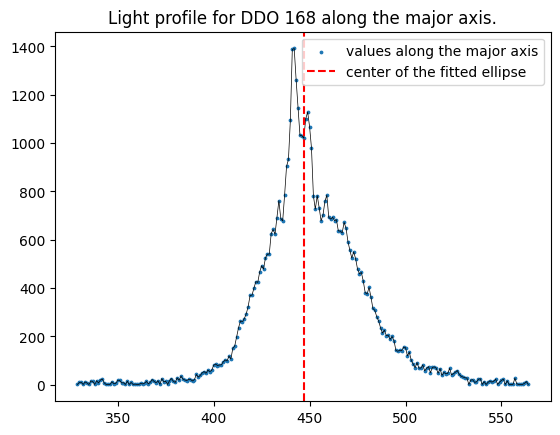

Threshold value: 524.5390892207532
Center of galaxy  (Equal Area on both sides of the center line): 449


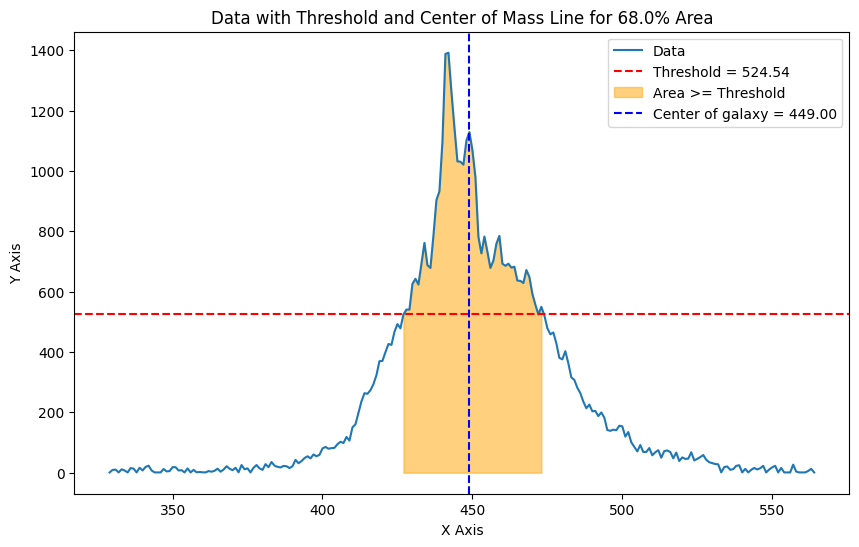

TypeError: get_line_values() takes 4 positional arguments but 5 were given

In [39]:
galaxy_name = "DDO 168"
image_168 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO 168\non_shifted_background_d168v.fits"))
list_of_ellipse_data = [theta_deg, 59.01, 21.11]
x_ax, y_list, values_along_line, center_of_mass_x, center_of_mass_y = get_line_profile_and_center(image_168, list_of_ellipse_data, int(297.981 + 150), int(275.67 + 175), int(297.981 + 150 - 2*59.01), False)
theta = degrees_to_radians(theta_deg)
x_ax, values_along_line, y_list = RD(image_168, 3.5, 1.134,list_of_ellipse_data, int(center_of_mass_x), int(center_of_mass_y), int(center_of_mass_x - 2*59.01), False)

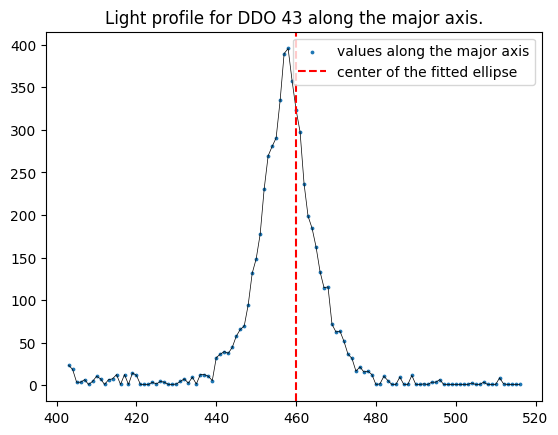

Threshold value: 162.6090748115222
Center of galaxy  (Equal Area on both sides of the center line): 458


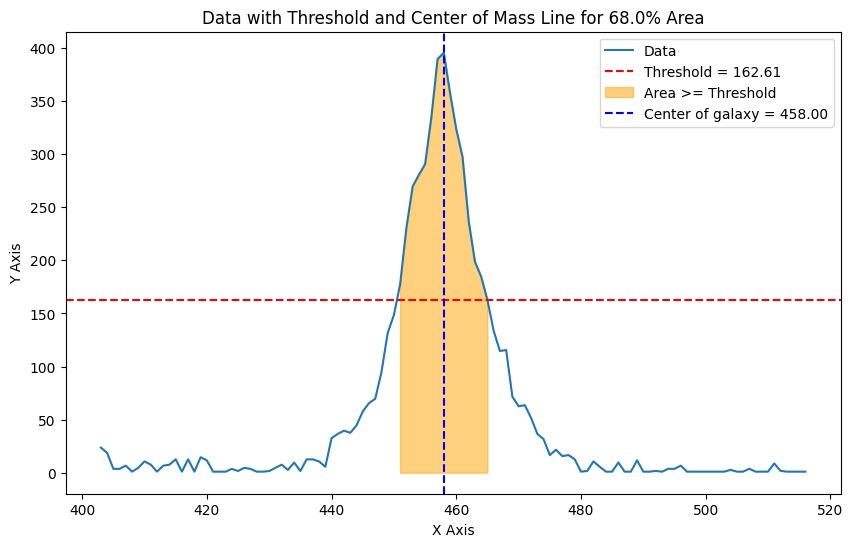

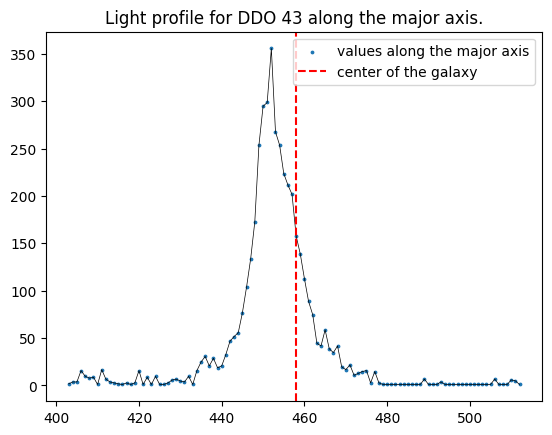

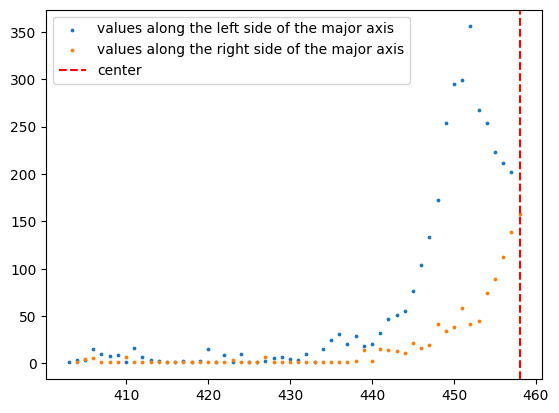

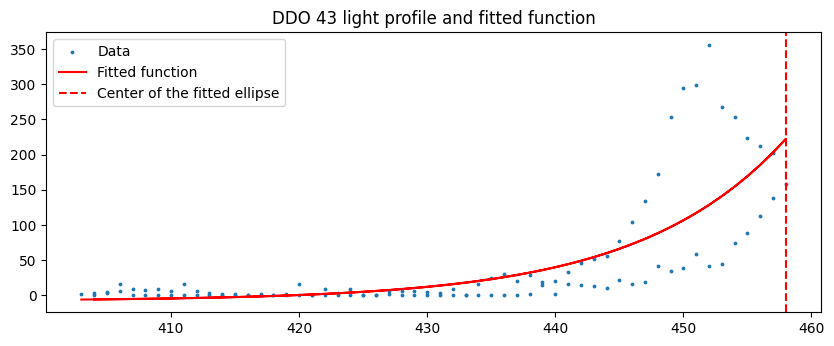

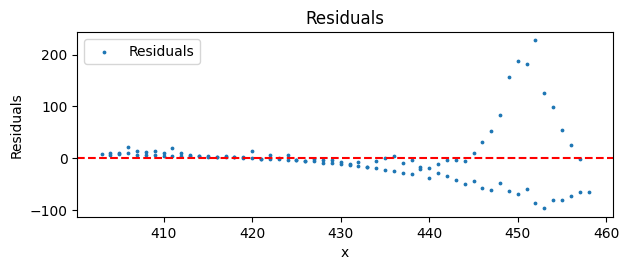

Exponential fit function is a * exp(b * (x - x0)) + c
a is 0.0000 +/- 0.0000
b is 0.0873 +/- 0.0178
c is -7.7748 +/- 9.7937
x0 is -0.0036 +/- 6047.4397
RD is 11.4557 pixels
RD for DDO 43 is 0.22043381203710202 kpc


In [33]:
galaxy_name = "DDO 43"
x_start = 400
y_start = 390
a_half = 28.669
b_half = 14.991
theta_deg = 24.334
X_center = 60.826
y_center = 63.723

image_168 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO43\non_shifted_background_d43v.fits"))
list_of_ellipse_data = [theta_deg, a_half, b_half]
x_ax, y_list, values_along_line, center_of_mass_x, center_of_mass_y = get_line_profile_and_center(image_168, list_of_ellipse_data, int(X_center+x_start), int(y_center+y_start), int(X_center+x_start - (2*a_half)), False)
theta = degrees_to_radians(theta_deg)
x_ax, values_along_line, y_list = R_D(image_168, 3.5, 1.134, list_of_ellipse_data, int(center_of_mass_x), int(center_of_mass_y), int(X_center+x_start - (2*a_half)), False)